

<br>
<br>


<h1><center> SFS </center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


#### paths

In [1]:


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"
abspath_discrimination_lines = abspath_study +"discrimination_lines/"
abspath_test = abspath_study +"test/"
abspath_er_leakage_study = abspath_study +"20230519__er_leakage_study/"


#### imports

In [2]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import time
from datetime import timedelta
import datetime
import matplotlib.gridspec as gridspec



# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs


#### study assumptions

In [3]:


# default study parameters
default_wimp_eroi_kev_ee = [1.4, 11.6] # WIMP energy region of interest in keV_ee
default_wimp_eroi_kev_nr = [sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[0], "ER"), sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[1], "ER")] # WIMP energy region of interest in keV_nr
print(f"WIMP EROI: [{default_wimp_eroi_kev_ee[0]:.1f},{default_wimp_eroi_kev_ee[1]:.1f}] keV_ER")
print(f"WIMP EROI: [{default_wimp_eroi_kev_nr[0]:.1f},{default_wimp_eroi_kev_nr[1]:.1f}] keV_NR")
default_wimp_mass_gev = 100 # WIMP mass in GeV
default_wimp_nucleon_cross_section_cm2 = 5e-49 # WIMP-nucleon cross-section in cm^2


# default study settings
default_number_of_medium_stat_simulations = 5*10**5 # number of events simulated in medium statistics simulations
default_number_of_high_stat_simulations = 5*10**6 # number of events simulated in high statistics simulations
default_simulation_energy_bins = 50 # number of energy bins used for the spectra simulation
default_recoil_energy_simulation_window_er = [0.8*default_wimp_eroi_kev_ee[0], default_wimp_eroi_kev_ee[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_recoil_energy_simulation_window_nr = [0.8*default_wimp_eroi_kev_nr[0], default_wimp_eroi_kev_nr[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
print(f"simulation EROI: [{default_recoil_energy_simulation_window_er[0]:.1f},{default_recoil_energy_simulation_window_er[1]:.1f}] keV_ER")
print(f"simulation EROI: [{default_recoil_energy_simulation_window_nr[0]:.1f},{default_recoil_energy_simulation_window_nr[1]:.1f}] keV_NR")
default_number_of_discrimination_line_energy_bins = 50 # number of energy bins into which the WIMP EROI is subdivided for the computation of the ER rejection
default_nr_acceptance = 0.50 # acceptance of the (not in percent) of the nuclear recoils on which the NR computation is based
default_seed_for_baseline_assessment = 2615 # 2614


# default detector parameters
default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
default_param_eLife_us = 10000
default_param_e_drift = 200
default_param_g1 = 0.125
default_param_E_gas = 8


WIMP EROI: [1.4,11.6] keV_ER
WIMP EROI: [7.3,54.9] keV_NR
simulation EROI: [1.1,17.4] keV_ER
simulation EROI: [5.9,82.3] keV_NR



<br>
<br>


# DARWIN Baseline Detector Definition


<br>
<br>


In [4]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : default_param_g1,         # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.35,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 1.0,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 150,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.125,                    # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 2.0,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : 10.0,                     # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : default_param_E_gas,      # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : default_param_eLife_us,   # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 1.9,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 900.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 100.0,                    # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1700.0,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1250.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1300.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 2650.0,                   # top of drift volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 2657.0,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 2643.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 50.0,                     # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}



# non-NEST detector parameters
darwin_baseline_detector_drift_field_v_cm = default_param_e_drift # drift field of the darwin baseline design in V/cm
darwin_baseline_detector_runtime_y = 5 # live time of the experiment in years
darwin_baseline_detector_fiducial_mass_t = 30 # fiducial volume of the detector in metric tonnes


# adjusting drift times according to detector dimension
darwin_baseline_detector_dict = sfs.adjust_detector_drift_time_parameters(darwin_baseline_detector_dict, darwin_baseline_detector_drift_field_v_cm)


# saving the 'detector_dict' of the darwin baseline detector
sfs.write_dict_to_json(abspath_detectors +"example__detector__darwin_baseline_detector.json", darwin_baseline_detector_dict)


# derived parameters
darwin_baseline_detector_g2 = sfs.compute_g2_from_detector_configuration(darwin_baseline_detector_dict)
print(f"g2: {darwin_baseline_detector_g2} phd per primary electron")
darwin_baseline_detector_drift_velocity_mm_usec = sfs.compute_drift_velocity_from_detector_configuration(darwin_baseline_detector_dict,darwin_baseline_detector_drift_field_v_cm)
print(f"drift velocity: {darwin_baseline_detector_drift_velocity_mm_usec} mm/usec")
darwin_baseline_detector_active_xenon_mass_t = sfs.calc_active_xenon_mass_of_detector_dict_t(darwin_baseline_detector_dict)
print(f"active xenon mass: {darwin_baseline_detector_active_xenon_mass_t} tonnes")
max_drift_time_usec = (darwin_baseline_detector_dict['TopDrift']-darwin_baseline_detector_dict['cathode'])/darwin_baseline_detector_drift_velocity_mm_usec
print(f"max drift time: {max_drift_time_usec} usec")
darwin_baseline_detector_fiducial_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_fiducial_mass_t
print(f"fiducial exposure: {darwin_baseline_detector_fiducial_exposure_ty} ty")
darwin_baseline_detector_active_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_active_xenon_mass_t
print(f"active exposure: {darwin_baseline_detector_active_exposure_ty} ty")



g2: 45.403972482531884 phd per primary electron
drift velocity: 1.5248620549967127 mm/usec
active xenon mass: 40.449157162641384 tonnes
max drift time: 1705.0722663602546 usec
fiducial exposure: 150 ty
active exposure: 202.2457858132069 ty



<br>
<br>


# Spectra Definition


<br>
<br>



#### plotting differential ER and NR backgrounds
WIMPs are computed with [Jelle Aalber's `wimprates` library](https://github.com/JelleAalbers/wimprates).

In [5]:


if [False,True][0]:


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][1]:
        sfs.gen_spectrum_plot(
            spectra_list = ["er_pp", "er_be7" , "er_nunubetabeta", "combined_er_background", "er_rn222", "er_rn222_1ubqpkg"],
            abspath_spectra_files = abspath_resources,
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [1,100],
            plot_ylim = [1e-1,1e+2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.15, 0.55, 0.25, 0.45],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
#            flag_output_abspath_list = [],
            flag_output_filename = "example__spectrum_plot__differential_combined_er_background.png",
            flag_shade_wimp_eroi = default_wimp_eroi_kev_ee,
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][1], )


    #---------------------------------------
    # ER background + WIMPs
    #---------------------------------------


    if [False,True][0]:
        sfs.gen_spectrum_plot(
            #spectra_list = ["nr_wimps_nat_xe", "nr_wimps_wimprates", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            #spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_34t", "nr_neutrons_28t", "nr_neutrons_20t", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_new_baseline", "nr_neutrons_new_improved_ptfe_and_pmts_and_cryo", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb"],
            abspath_spectra_files = abspath_resources,
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            },
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [2,100],
        #        plot_ylim = [3e-5,2e-1],
            plot_ylim = [1e-4,1e-2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.60, 0.35, 0.38, 0.73],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
        #        flag_output_abspath_list = [],
            flag_shade_wimp_eroi = default_wimp_eroi_kev_nr,
            flag_output_filename = "example__spectrum_plot__differential_combined_nr_background_wimps.pdf",
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][2], )



#### generating histogrammed ER, NR, and WIMP spectra

In [6]:


if [False,True][0]:


    #---------------------------------------
    # custom spectrum
    #---------------------------------------


    if [False,True][0]:
        custom_spectrum_dict = {
            "seed": "1",
            "field_drift[V/cm]": str(darwin_baseline_detector_drift_field_v_cm),
            "x,y,z-position[mm]": "-1",
            "numEvts": [
                10000,
                10000,
                10000,
                10000,
                10000,
            ],
            "type_interaction": "ER",
            "E_min[keV]": [
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.00),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.25),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.50),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.75),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 1.00),
            ],
            "E_max[keV]": [
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.00),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.25),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.50),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.75),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 1.00),
            ],
            # NOTE: All of the key-value pairs below are part of the 'give_spectrum_dict' functionality.
            # NOTE: They are not required to just run NEST via the 'execNEST' function in SFS, as shown in the cell below.
            # NOTE: The above parameters are those that are being passed to the 'execNEST' binary.
            #"latex_label": "\\textbf{combined ER background (goal)}",
            #"color": "#C1002A",
            #"linestyle": "-",
            #"linewidth": 2,
            #"zorder": 2,
            #"differential_rate_computation": "spectrum_sum",
            #"constituent_spectra_list": [],
            #"recoil_energy_kev_list": [],
            #"exposure_t_y": 150,
            #"num_events": "exposure_poisson",
            #"flag_verbose": false,
            #"flag_spectrum_type": "integral",
            #"differential_rate_parameters": {},
        }
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__custom_spectrum_dict.json", custom_spectrum_dict)


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][1]:
        er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background.json", er_background_spectrum_dict)


    # generating the ER background spectrum dict with medium statistics
    if [False,True][0]:
        medium_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json", medium_statistics_er_background_spectrum_dict)


    # generating the ER background spectrum dict with high statistics
    if [False,True][0]:
        high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_high_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json", high_statistics_er_background_spectrum_dict)


    #---------------------------------------
    # NR background
    #---------------------------------------


    # generating the NR background spectrum dict
    if [False,True][1]:
        nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background.json", nr_background_spectrum_dict)


    # generating the NR background spectrum dict with medium statistics
    if [False,True][1]:
        medium_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json", medium_statistics_nr_background_spectrum_dict)


    # generating the NR background spectrum dict with high statistics
    if [False,True][0]:
        high_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_high_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json", high_statistics_nr_background_spectrum_dict)


    #---------------------------------------
    # WIMPs
    #---------------------------------------


    # generating the WIMP spectrum dict
    if [False,True][1]:
        wimp_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "nr_wimps_wimprates",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            }
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__wimps.json", wimp_spectrum_dict)



#### plotting the histogrammed ER, NR, and WIMP spectra

In [7]:


if [False,True][0]:


    # data retrieval
    er_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json")
    nr_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json")
    wimp_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json")


    # plotting the spectra the simulation is fed with (as would be expected in a realistic DARWIN detector)
    sfs.gen_spectrum_plot(
        spectra_list = [er_background_spectrum_dict, nr_background_spectrum_dict, wimp_spectrum_dict],
        abspath_spectra_files = abspath_resources,
        #spectra_list = [nr_test_spectrum_dict],
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        plot_log_y_axis = True,
        plot_log_x_axis = False,
        plot_xlim = [0,default_recoil_energy_simulation_window_nr[1]*0.65],
        plot_ylim = [],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][0],
        plot_legend = True,
        plot_legend_bbox_to_anchor = [0.3, 0.5, 0.7, 0.5],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 9,
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__integral_combined_er_nr_spectra_wimps.png",
        flag_shade_wimp_eroi = [],
        flag_verbose = False,)




<br>
<br>


# Executing NEST


<br>
<br>


#### executing NEST to generate signature ndarrays

In [8]:


if [False,True][0]:


    #---------------------------------------
    # custom spectrum
    #---------------------------------------


    if [False,True][0]:
        custom_spectrum_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__custom_spectrum_dict.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,
            flag_detector_installation="do_not_install",)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__custom_spectrum.npy", custom_spectrum_ndarray)


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][1]:
        er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            #{ # one can specify only a few parameters that will be overwritten in 'baseline_detector_dict'
            #    "g1"       : 0.15,
            #},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy", er_background_ndarray)


    if [False,True][0]:
        medium_statistics_er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy", medium_statistics_er_background_ndarray)


    if [False,True][0]:
        high_statistics_er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            baseline_detector_dict = darwin_baseline_detector_dict,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy", high_statistics_er_background_ndarray)


    #---------------------------------------
    # NR background
    #---------------------------------------


    if [False,True][1]:
        nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # an empty 'detector_dict' will use the installed detector
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy", nr_background_ndarray)


    if [False,True][0]:
        medium_statistics_nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy", medium_statistics_nr_background_ndarray)


    if [False,True][0]:
        high_statistics_nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
           flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy", high_statistics_nr_background_ndarray)


    #---------------------------------------
    # WIMPs
    #---------------------------------------


    if [False,True][1]:
        wimp_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy", wimp_ndarray)



#### computing ER/NR discrimination line

In [9]:


if [False,True][0]:


    # computing discrimination line
    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
        er_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy"),
        nr_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
        detector_dict = darwin_baseline_detector_dict,
        min_energy = default_wimp_eroi_kev_ee[0],
        max_energy = default_wimp_eroi_kev_ee[1],
        bin_number = default_number_of_discrimination_line_energy_bins,
        nr_acceptance = default_nr_acceptance,
        approx_depth = 24,
        verbose =True,)
    sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)



#### plotting event signatures

In [10]:


if [False,True][0]:


    sfs.gen_signature_plot(
        signature_dict_list = [
#            {
#                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__custom_spectrum.npy"),
#                "label" : r"custom spectrum",
#                "alpha" : 0.5,
#                "s"     : 1,
#                "facecolors" : "green",
#            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy"),
                "label" : r"combined ER background",
                "alpha" : 1.0,
                "s"     : 1.6,
                "facecolors" : sfs.color_ers_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy"),
                "label" : r"combined NR background",
                "alpha" : 1.0,
                "s"     : 4,
                "facecolors" : sfs.color_nrs_default,
                "linewidths" : 0.25,
                "edgecolors" : "white",
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy"),
                "label" : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\frac{\mathrm{GeV}}{c^2}$, $" +f"{str(default_wimp_nucleon_cross_section_cm2)[0]}" +r"\cdot 10^{" f"{str(default_wimp_nucleon_cross_section_cm2)[-3:]}" +r"}\,\mathrm{cm^2}$)",
                "alpha" : 1,
                "s"     : 4,
                "facecolors" : sfs.color_wimps_default,
                "linewidths" : 0.25,
                "edgecolors" : "white",
            },
        ],
        detector_dict = darwin_baseline_detector_dict,
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        **[
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,110],
                "plot_ylim" : [1e2,2e4],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][0],
            },
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,800],
                "plot_ylim" : [6e+1, 1e+3],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][1],
            },
        ][1],
#        plot_text_dict_list = [
#            {
#                "s"     : r"combined ER background",
#                "x"     : 0.55,
#                "y"     : 0.75,
#                "color" : sfs.color_ers_default,
#            },
#            {
#                "s"     : r"combined NR background",
#                "x"     : 0.35,
#                "y"     : 0.25,
#                "color" : sfs.color_nrs_default,
#            },
#            {
#                "s"     : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\frac{\mathrm{GeV}}{c^2}$, $" +f"{str(default_wimp_nucleon_cross_section_cm2)[0]}" +r"\cdot 10^{" f"{str(default_wimp_nucleon_cross_section_cm2)[-3:]}" +r"}\,\mathrm{cm^2}$)",
#                "x"     : 0.15,
#                "y"     : 0.35,
#                "color" : sfs.color_wimps_default,
#            },
#        ],
        plot_energy_contours = list(np.linspace(start=default_wimp_eroi_kev_ee[0], stop=default_wimp_eroi_kev_ee[1], num=5, endpoint=True)),
        plot_energy_contours_rotations = [-84, -77, -69, -63, -55],
        plot_energy_contours_pos_NR = [0.075, 0.260, 0.450, 0.635, 0.825],
        plot_energy_contours_pos_ER = [0.110, 0.295, 0.485, 0.675, 0.860],
        plot_discrimination_line_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json"), # generated above
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__signature_plot__combined_er_nr_spectra_wimps.png",
        flag_profile = ["default"][0],
        flag_gray_out_events_outside_wimp_eroi = [True, False][0],
        flag_verbose = True,
        flag_re_plot_events_below_discrimination_line = {
            "s" : 12,
            "linewidths" : 0.25,
            "edgecolors" : "white",
            "zorder" : 20,
        },
        flag_histogram_nr_background = {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
                "colorbar_label"    : r"NR background PDF",
                "n_bins_x"          : 100,
                "n_bins_y"          : 100,
                "cmap"              : "GnBu",
            },
        plot_legend = True,
    )





<br>
<br>


# Ph.D. Study: ER Leakage Fraction


<br>
<br>



### Leakage Fraction Scan for Default Parameters

#### data generation

In [11]:
# linspace, but with 'startpoint=False': np.linspace(380, 20, 30, endpoint=False)[::-1],      # [20, 380]
# print python print output to file: https://howtodoinjava.com/python-examples/python-print-to-file/

if [False,True][1]:


    # definitions
    dataset_name = "lf_scan_for_default_parameters"
    # first simulation run
    n_simulations = 10
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : list(np.linspace(num=n_simulations, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        },
        "g1_scan" : {
            "g1" : list(np.linspace(num=n_simulations, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        },
        "E_gas_scan" : {
            "E_gas" : list(np.linspace(num=n_simulations, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "eLife_us_scan" : {
            "eLife_us" : list(np.linspace(num=n_simulations, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        },
    }
    # second simulation run (to increase statistics of run 1)
    #n_simulations = 4*(n_simulations-1)+1
    #subdataset_dict = {
    #    "e_drift_scan" : {
    #        "e_drift" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True))) if k%4!=0],
    #    },
    #    "g1_scan" : {
    #        "g1" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True))) if k%4!=0],
    #    },
    #    "E_gas_scan" : {
    #        "E_gas" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True))) if k%4!=0],
        },
        "eLife_us_scan" : {
            "eLife_us" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True))) if k%4!=0],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



#### plotting

In [12]:


if [False,True][1]:


    # varable input
    data = {
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230522_0301__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[0.05,\,2.0]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230522_0522__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "red",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[4.0,\,12.0]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
        "e_drift"   : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0412__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230521_0412__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230522_0040__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
            "color" : "blue",
            "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[20,\,380]$",
            "range" : default_param_range_e_drift,
            "marker": "P",
            "zorder": 3,
        },
        "eLife_us"  : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0625__lf_scan_for_default_parameters__eLife_us_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230521_0625__lf_scan_for_default_parameters__eLife_us_scan.npy"), np.load(abspath_er_leakage_study +"20230522_0743__lf_scan_for_default_parameters__eLife_us_scan.npy")], "eLife_us"),
            "color" : "purple",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[0.5,\,19.5]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
    }
    # figure
    fig = plt.figure(figsize=[5.670, 5.670*9/16], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.085, 0.905, 0.010],
        height_ratios = [0.020, 0.865, 0.115],)

    # axes
    ax1 = fig.add_subplot(spec[1,1])
    ax1.set_xlabel(r"relative parameter value, ${^{\bullet}p}$", fontsize=11)
    ax1.set_ylabel(r"reduced leakage fraction, $\mathcal{D}\vert_{p}({^{\bullet}p})$ / $\permil$", fontsize=11, labelpad=5)
    ax1.set_xlim([0.025, 0.975])
    ax1.set_ylim([3.0, 10.0])
    #ax1.set_yscale('log')


    # plotting
    for k, dataset in enumerate([*data]):
        # data modification
        x_data_rel              = [(x-data[dataset]["range"][0])/(data[dataset]["range"][1]-data[dataset]["range"][0]) for x in data[dataset]["data"][dataset]]
        y_data_permil           = [1000*y for y in data[dataset]["data"]["leakage_fraction"]]
        y_data_unc_permil       = [1000*y for y in data[dataset]["data"]["leakage_fraction_uncertainty"]]
        y_data_unc_permil_upper = [y +y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        y_data_unc_permil_lower = [y -y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        # plotting uncertainty bands
        ax1.fill_between(
            x = x_data_rel,
            y1 = y_data_unc_permil_upper,
            y2 = y_data_unc_permil_lower,
            color = data[dataset]["color"],
            alpha = 0.5,
            linewidth = 0,
            zorder = data[dataset]["zorder"],
        )
        ax1.plot(
            x_data_rel,
            y_data_permil,
            linewidth       = 1,
            linestyle       = "-",
            color          = data[dataset]["color"],
            zorder = data[dataset]["zorder"],
        )
        # plotting simulation points
        if [False,True][1]:
            ax1.errorbar(
                x               = x_data_rel,
                y               = y_data_permil,
                yerr            = y_data_unc_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                fmt             = "",
                ecolor          = data[dataset]["color"],
                elinewidth      = 1,
                capsize         = 1.2,
                barsabove       = True,
                label           = data[dataset]["label"],
                zorder          = data[dataset]["zorder"],
                capthick        = 0.5,)
            ax1.plot(
                x_data_rel,
                y_data_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                zorder          = data[dataset]["zorder"],
                alpha           = 1,)
    # plotting default parameters
    if [False,True][1]:
        ax1.errorbar(
            x               = 0.5,
            y               = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            yerr            = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 0.5,
            markeredgecolor = "black",
            linestyle       = "",
            fmt             = "",
            ecolor          = "black",
            elinewidth      = 1,
            capsize         = 1.2,
            barsabove       = True,
            label           = r"${^{\star}P}$",
            zorder          = 5,
            capthick        = 0.5,)
        ax1.plot(
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 9.0,
            markeredgecolor = "black",
            linestyle       = "",
            zorder          = 5,
            alpha           = 1,)
        
    # legend
    ax1.legend()

    # saving
    for abspath in abspath_list_plots:
        figure_name = "lekage_fraction_function_reduced_to_all_scanned_parameters"
        fig.savefig(abspath +figure_name +".png")
        #fig.savefig(abspath +figure_name +".pdf")



### Electron Lifetime Investigation

#### data generation

In [13]:
#default_param_range_eLife_us = [500, 19500] # in us, baseline value: 10000 us

#default_param_range_g1 = [0.050, 0.20] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [4.0, 12.0] # in kV/cm, baseline value: 8 kV/cm
#default_param_range_e_drift = [20, 380] # in V/cm, baseline value: 200 V/cm


if [False,True][0]:


    # definitions
    dataset_name = "electron_lifetime_investigation"
    # manually selecting eight detector configurations
    # note that every subdataset corresponds to one curve as only a single parameter value is given per other parameter
    n_samples_per_eLife_us_curve = 19
    subdataset_dict = {
        # plateau independent of g1 and g2
        "1" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.140],
            "E_gas"    : [10],
            "e_drift"  : [200],
        },
        "2" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.090],
            "E_gas"    : [5],
            "e_drift"  : [200],
        },
        # bad and good detectors
        "3" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.090],
            "E_gas"    : [5],
            "e_drift"  : [50],
        },
        "4" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.140],
            "E_gas"    : [10],
            "e_drift"  : [290],
        },
        # plateau dependent on e_drift
        "5" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.125],
            "E_gas"    : [7],
            "e_drift"  : [50],
        },
        "6" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.125],
            "E_gas"    : [7],
            "e_drift"  : [380],
        },
        "7" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_eLife_us_curve, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "g1"       : [0.125],
            "E_gas"    : [10],
            "e_drift"  : [290],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



### Electron Lifetime + Drift Field

#### data generation

In [52]:
#default_param_range_eLife_us = [500, 19500] # in us, baseline value: 10000 us
#default_param_range_e_drift = [20, 380] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.050, 0.20] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [4.0, 12.0] # in kV/cm, baseline value: 8 kV/cm


if [False,True][1]:


    # definitions
    dataset_name = "electron_lifetime_and_drift_field"
    # manually selecting eight detector configurations
    # note that every subdataset corresponds to one curve as only a single parameter value is given per other parameter
    n_samples_per_hist2d_axis = 11
    subdataset_dict = {
        #"baseline_parameters" : {
        #    "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        #    "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        #    "g1"       : [default_param_g1],
        #    "E_gas"    : [default_param_E_gas],
        #},
        #"bad_g1_bad_E_gas" : {
        #    "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        #    "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        #    "g1"       : [default_param_range_g1[0]],
        #    "E_gas"    : [default_param_range_E_gas[0]],
        #},
        #"good_g1_good_E_gas" : {
        #    "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        #    "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        #    "g1"       : [default_param_range_g1[1]],
        #    "E_gas"    : [default_param_range_E_gas[1]],
        #},
        #"bad_g1_good_E_gas" : {
        #    "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        #    "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        #    "g1"       : [default_param_range_g1[0]],
        #    "E_gas"    : [default_param_range_E_gas[1]],
        #},
        "good_g1_bad_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[1]],
            "E_gas"    : [default_param_range_E_gas[0]],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



#### plotting

sum of 'width_ratios'=1.0000000000000002
sum of 'height_ratios'=1.0
'lf_min_permil_list'=[9.3593759944558, 2.4382083262144416, 3.929419004806589, 3.898573242804182]
'lf_max_permil_list'=[28.802259167250543, 9.066044480169566, 11.433699734650581, 13.160185464816788]
'lf_min_permil_val'=2.4382083262144416
'lf_max_permil_val'=28.802259167250543


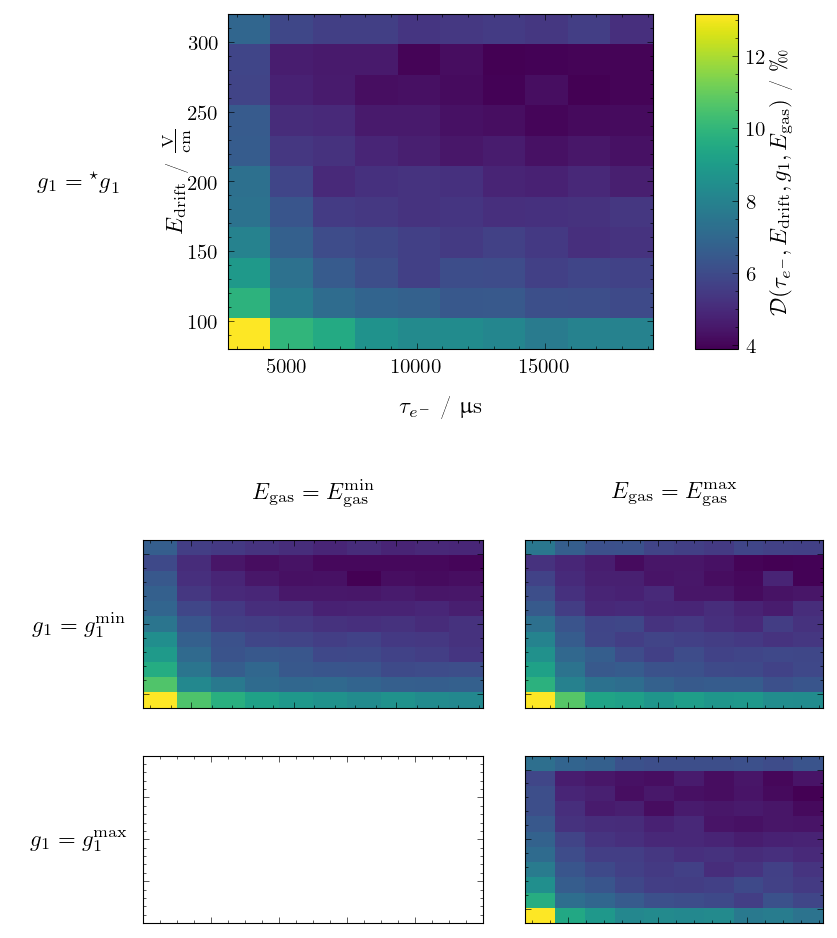

In [59]:


if [False,True][1]:


    # figure
    fig_aspect_ratio = 2*9/16
    fig = plt.figure(figsize=[5.670, 5.670*fig_aspect_ratio], dpi=150, constrained_layout=False) 
    width_ratios = [
        x_rel_g1_E_gas_label_width := 0.15,
        x_rel_main_plot_y_label_width := 0.10,
        x_rel_main_plot_1_width := 0.30,
        x_rel_main_plot_2_width := 0.05,
        x_rel_main_plot_3_width := 0.15,
        x_rel_main_plot_2_width, # distance between main plot and cbar
        x_rel_cbar_plot_width := 0.05,
        x_rel_main_plot_y_label_width, # colorbar label width
        x_rel_dist_to_right_border := 0.05,
    ]
    height_ratios = [
        y_rel_dist_to_border := 0.025,
        y_rel_main_plot_height := 0.35,
        y_rel_main_plot_x_label_height := 0.10,
        y_rel_g1_E_gas_label_height := 0.10,
        y_rel_side_plot_height := 0.175,
        y_rel_side_plot_dist := 0.05,
        y_rel_side_plot_height,
        y_rel_dist_to_border,
    ]
    spec = gridspec.GridSpec(
        ncols = 9,
        nrows = 8,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = width_ratios,
        height_ratios = height_ratios,)
    print(f"sum of 'width_ratios'={sum(width_ratios)}")
    print(f"sum of 'height_ratios'={sum(height_ratios)}")


    # axes
    plot_axes = [
        ax_plot_main              := fig.add_subplot(spec[1,2:5]),
        ax_plot_cbar              := fig.add_subplot(spec[1,6]),
        ax_plot_sub_upper_left    := fig.add_subplot(spec[4, 1:3]),
        ax_plot_sub_upper_right   := fig.add_subplot(spec[4, 4:8]),
        ax_plot_sub_lower_left    := fig.add_subplot(spec[6, 1:3]),
        ax_plot_sub_lower_right   := fig.add_subplot(spec[6, 4:8]),
    ]
    label_axes = [
        ax_label_main_x           := fig.add_subplot(spec[2, 2:5]),
        ax_label_main_y           := fig.add_subplot(spec[1, 1]),
        ax_label_main_y_side      := fig.add_subplot(spec[1, 0]),
        ax_label_colorbar         := fig.add_subplot(spec[1, 7]),
        ax_label_upper_left_top   := fig.add_subplot(spec[3, 1:3]),
        ax_label_upper_right_top  := fig.add_subplot(spec[3, 4:8]),
        ax_label_upper_left_left  := fig.add_subplot(spec[4, 0]),
        ax_label_lower_left_left  := fig.add_subplot(spec[6, 0]),
    ]
    fontsize_main_axis_label = 11
    fontsize_side_param_label = 11
    
    
    # printing axis labels
    axis_labels = [
        {
            "label"    : r"$E_{\mathrm{drift}}$ / $\frac{\mathrm{V}}{\mathrm{cm}}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y,
            "offset"   : [-0.1,0],
        },
        {
            "label"    : r"$\tau_{e^-}$ / $\mathrm{\upmu s}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 0,
            "axis"     : ax_label_main_x,
            "offset"   : [0,-0.1],
        },
        {
            "label"    : r"$\mathcal{D}(\tau_{e^-}, E_{\mathrm{drift}}, g_1, E_{\mathrm{gas}})$ / $\permil$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_colorbar,
            "offset"   : [0,0],
        },
        {
            "label"    : r"$g_1 = {^{\star}g}_1$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_main_y_side,
            "offset"   : [0,0],
        },
        {
            "label"    : r"$g_1=g_1^{\mathrm{min}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_left_left,
            "offset"   : [0,0],
        },
        {
            "label"    : r"$g_1=g_1^{\mathrm{max}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_lower_left_left,
            "offset"   : [0,0],
        },
        {
            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{min}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_left_top,
            "offset"   : [0,0],
        },
        {
            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{max}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_right_top,
            "offset"   : [0,0],
        },
    ]
    for k, label in enumerate(axis_labels):
        label["axis"].text(
            s = label["label"],
            x = 0.5 +label["offset"][0],
            y = 0.5 +label["offset"][1],
            transform = label["axis"].transAxes,
            horizontalalignment = "center",
            verticalalignment = "center",
            fontsize = label["fontsize"],
            color = "black",
            rotation = label["rotation"],
        )
        # hiding axis spines
        label["axis"].set_axis_off()
    # hiding axis ticks
    for k, ax in enumerate([ax_plot_sub_upper_left, ax_plot_sub_upper_right, ax_plot_sub_lower_left, ax_plot_sub_lower_right]):
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    # plotting
    data = {
        "bad_g1_bad_E_gas"     : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0911__electron_lifetime_and_drift_field__bad_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_left,
        },
        "good_g1_good_E_gas"   : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_1455__electron_lifetime_and_drift_field__good_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_right,
        },
        "bad_g1_good_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_2005__electron_lifetime_and_drift_field__bad_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_right,
        },
        "baseline_parameters"  : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0416__electron_lifetime_and_drift_field__baseline_parameters.npy"),
            "axis"             : ax_plot_main,
        },
    }
    # data selection
    for subdata in [*data]:
        data[subdata]["data"] = data[subdata]["data"][data[subdata]["data"]["eLife_us"]>1000]
    lf_min_permil_list = [1000*np.min(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    lf_max_permil_list = [1000*np.max(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    print(f"'lf_min_permil_list'={lf_min_permil_list}")
    print(f"'lf_max_permil_list'={lf_max_permil_list}")
    lf_min_permil_val = min(lf_min_permil_list)
    lf_max_permil_val = max(lf_max_permil_list)
    print(f"'lf_min_permil_val'={lf_min_permil_val}")
    print(f"'lf_max_permil_val'={lf_max_permil_val}")
    for k, subdata in enumerate([*data]):
        h2d = data[subdata]["axis"].hist2d(
            x = data[subdata]["data"]["eLife_us"],
            y = data[subdata]["data"]["e_drift"],
            bins = [len(set(data[subdata]["data"]["eLife_us"])), len(set(data[subdata]["data"]["e_drift"]))],
#            vmin = lf_min_permil_val,
#            vmax = lf_max_permil_val,
            cmap = "viridis",
#            norm = mpl.colors.LogNorm(),
#            weights = (1-data[subdata]["data"]["leakage_fraction"])*1000,)
            weights = data[subdata]["data"]["leakage_fraction"]*1000,)
    fig.colorbar(h2d[3], cax=ax_plot_cbar)

    
    
    #ax1.set_xlabel(r"relative parameter value, ${^{\bullet}p}$", fontsize=11)
    #ax1.set_ylabel(r"reduced leakage fraction, $\mathcal{D}\vert_{p}({^{\bullet}p})$ / $\permil$", fontsize=11, labelpad=5)
    #ax1.set_xlim([0.025, 0.975])
    #ax1.set_ylim([3.0, 10.0])
    #ax1.set_yscale('log')


    # plotting
        

    # saving
    plt.show()
    for abspath in abspath_list_plots:
        figure_name = "lekage_fraction_for_electron_lifetime_and_drift_field"
        fig.savefig(abspath +figure_name +".png")
        #fig.savefig(abspath +figure_name +".pdf")




<br>
<br>


# Study: Maximum Likelihood Sensitivity Estimation


<br>
<br>



#### computing exclusion line

In [ ]:


from scipy.optimize import minimize


# defining test function
def testfunc(ix,iy,iz):
    val = np.array(0)
    x = np.float128(ix)
    y = np.float128(iy)
    z = np.float128(iz)
    val = 4.2*x**2 +3.1*y**2 +2.4*z**2
    return val


# minimizing test function
minimum = minimize(
    fun    = lambda x : testfunc(x[0],x[1],x[2]),
    x0     = [0,1,1],
    #bounds = [[0,5000000], [0,5000000], [0,50000000]],
    options = {
        "xtol" : 0.000000000000000000000000001,
        "ftol" : 0.000000000000000000000000001},
#    method = None,
    method = "Powell",
#    method = "Nelder-Mead",
)


# printing output
print(f"test function output: {testfunc(1,1,1)}\n")
print(f"minimum output:\n{minimum}\n")
print(f"minimum location: {minimum.x}\n")
print(f"minimum value: {testfunc(minimum.x[0], minimum.x[1], minimum.x[2])}\n")





In [ ]:


if [False,True][0]:


    wimp_parameter_exclusion_curve_dict = sfs.calculate_wimp_parameter_exclusion_curve(
        # physical detector parameters
        detector__drift_field_v_cm                                       = darwin_baseline_detector_drift_field_v_cm,
        detector__nest_parameter_dict                                    = darwin_baseline_detector_dict,
        detector__runtime_y                                              = darwin_baseline_detector_runtime_y,
        detector__fiducial_mass_t                                        = darwin_baseline_detector_fiducial_mass_t,
        detector__detector_name                                          = "darwin_baseline_detector_sensitest",
        # physical spectrum parameters
        spectrum__default_spectrum_profiles                              = sfs.spectrum_dict_default_dict,
        spectrum__resources                                              = abspath_resources,
        spectrum__er_background_model                                    = "combined_er_background",
        spectrum__nr_background_model                                    = "combined_nr_background",
        spectrum__wimp_model                                             = "nr_wimps_wimprates",
        # simulation setting
        simulation__er_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_er,
        simulation__nr_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_nr,
        simulation__number_of_spectrum_energy_bins                       = default_simulation_energy_bins,
        simulation__number_of_upper_limit_simulations_per_wimp_mass      = 50, # 500
        simulation__number_of_pdf_calculation_events                     = 400000, # 4000000
        simulation__number_of_samples_for_expectation_value_computation  = 200,
        # limit calculation parameters
        limit__er_eroi_kev                                               = default_wimp_eroi_kev_ee,
        limit__nr_eroi_kev                                               = default_wimp_eroi_kev_nr,
        limit__wimp_mass_gev_list                                        = list(np.geomspace(start=10, stop=1000, num=10, endpoint=True)),
#        limit__wimp_mass_gev_list                                        = [10, 300],
        limit__number_of_cs1_bins                                        = 25, #40,
        limit__number_of_cs2_bins                                        = 25, #40,
        limit__cl                                                        = 0.9,
        # flags
        flag_verbose                                                     = [False, True, "high-level-only"][2],
        flag_plot_pdfs                                                   = [False, True, "er_nr_only"][1],
        flag_plot_test_statistics                                        = [False, True, 0.1][2],
        flag_plot_upper_limit_root_finding                               = [False, True, 0.1][2],
        flag_plot_upper_limit_distribution                               = [False, True, 0.1][1],
        flag_load_er_and_nr_signatures_for_pdf_calculation               = [False,True][1],
    )

    datestring = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    sfs.write_dict_to_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json", wimp_parameter_exclusion_curve_dict)

    # printing test output
    #print(f"\n\ntest output:")
    #print(f"\n'cs1_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs1_bin_edges']}")
    #print(f"\n'cs2_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs2_bin_edges']}")
    #for spectrum_string in ["er_background", "nr_background", "wimps"]:
    #    print(f"\n{spectrum_string}")
    #    print(f"'spectral_pdf': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['spectral_pdf']}")
    #    print(f"'number_of_expected_events_within_eroi': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['number_of_expected_events_within_eroi']}")



With 20 WIMP masses and 'sims_per_wimp_mass'=200 the code above took ~11.5h to run.


In [ ]:


if [False,True][0]:

    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json")
    wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230424_0507.json") # 6:38h


    sfs.plot_sensitivity_curve_comparison(
        sensitivity_curve_dict_list   = [wimp_parameter_exclusion_curve_dict_loaded],
        flag_comp_values              = [],#np.geomspace(start=2.3, stop=4.7, num=4, endpoint=True),
        cbar_label                    = r"drift field strength, $E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$",
        legend_colors                 = ["red"],
        plot_logxscale                = True,
        plot_logyscale                = True,
        output_abspath_list           = [path+ "test__plot_sensitivity_curve_comparison.png" for path in abspath_list_plots],
    )




<br>
<br>


# Study: Test NEST Output for Repetitions


<br>
<br>



In [ ]:

if [False,True][0]:
    
    
    # definitions
    test_seed_default = 1
    energy_list = [1.0, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0]
    n_test_datasets = len(energy_list)
    number_of_events_per_energy = 1000
    test_seed_random_list = [randrange(10000001) for k in range(n_test_datasets)]
    
    # running NEST
    print(f"running NEST")
    if [False,True][1]:
        nest_test_data_list = []
        for k in range(n_test_datasets):
            seed = randrange(10000001)
#            nest_test_spectrum_dict = {
#                    "seed": test_seed_random_list[k],
#                    "field_drift[V/cm]": "200",
#                    "x,y,z-position[mm]": "-1",
#                    "numEvts": [number_of_events_per_energy for j in range(len(energy_list))],
#                    "type_interaction": "ER",
#                    "E_min[keV]": energy_list,
#                    "E_max[keV]": energy_list,
#                }
            nest_test_spectrum_dict = {
                    "seed": seed,
                    "field_drift[V/cm]": "200",
                    "x,y,z-position[mm]": "-1",
                    "numEvts": [number_of_events_per_energy],
                    "type_interaction": "ER",
                    "E_min[keV]": [energy_list[k]],
                    "E_max[keV]": [energy_list[k]],
                }
            print(f"\tNEST run {k} of {n_test_datasets-1}")
            print(f"\t\trandom seed: {seed}")
            nest_test_ndarray = sfs.execNEST(
                spectrum_dict = nest_test_spectrum_dict,
                baseline_detector_dict = darwin_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                detector_dict = darwin_baseline_detector_dict,
                detector_name = "example__detector__darwin_baseline_detector",
                abspath_list_detector_dict_json_output = [abspath_detectors],
                flag_verbose = False,
                flag_print_stdout_and_stderr = False,)
            nest_test_data_list.append(nest_test_ndarray)

    
    # test 1: does the output contain duplicates
    print(f"test 1: does the output contain duplicates")
    for k, nest_test_ndarray in enumerate(nest_test_data_list):
        print(f"\texamining dataset {k} of {n_test_datasets-1} individually")
        for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
            length_list = len(list(nest_test_ndarray[column]))
            length_set = len(set(list(nest_test_ndarray[column])))
            print(f"\t\t'column': {column}")
            print(f"\t\t'length_list': {length_list}")
            print(f"\t\t'length_set': {length_set}")
    print(f"\tcomparing all datasets against each other")
    for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
        combined_data_list = [list(nest_test_ndarray[column]) for k, nest_test_ndarray in enumerate(nest_test_data_list)]
        combined_data_list = sum(combined_data_list, [])
        combined_data_set = set(combined_data_list)
        print(f"\t\t'column': {column}")
        print(f"\t\t'length_list': {len(combined_data_list)}")
        print(f"\t\t'length_set': {len(combined_data_set)}")
            
        
    
    
    
    


<br>
<br>


# Study: How Does S2/S1 Change with Energy?


<br>
<br>



In [ ]:


#test_ndarray = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy")
#print(test_ndarray.dtype.names)
# NEST ndarray column names:
# 'E_truth [keV]'
# 'field [V/cm]'
# 'tDrift [us]'
# 'X,Y,Z [mm]'
# 'Nph'
# 'Ne-'
# 'S1 [PE or phe]'
# 'S1_3Dcor [phd]'
# 'spikeC(NON-INT)'
# 'Ne-Extr'
# 'S2_rawArea [PE]'
# 'S2_3Dcorr [phd]'
abspath_test = abspath_study +"test/"

if [False,True][0]:
    import matplotlib.gridspec as gridspec


    # definitions
    print(f"definitions")
    test_seed_default = 1
    e_drift_v_cm = 10
    energy_list_kev = np.linspace(start=5.0, stop=100, num=20, endpoint=True)
    print(f"'energy_list_kev' = {energy_list_kev}")
    #energy_list_kev = [5.0, 15.0, 40.0]
    number_of_events_per_energy = 1000
    nest_data_sets = []


    # data generation
    print(f"data generation")
    for it in ["ER", "NR"]:
        for i, e_kev in enumerate(energy_list_kev):
            run_id = f"{it}__{str(int(e_kev))}"
            print(f"\trun_id: {run_id}")
            # defining spectra dicts
            print(f"\t\tdefining spectrum dict")
            nest_spectrum_dict = {
                "seed": test_seed_default,
                "field_drift[V/cm]": str(e_drift_v_cm),
                "x,y,z-position[mm]": "-1",
                "numEvts": [number_of_events_per_energy],
                "type_interaction": it,
                "E_min[keV]": [e_kev],
                "E_max[keV]": [e_kev],
            }
            # running NEST
            if [False,True][0]:
                print(f"\t\trunning NEST")
                nest_ndarray = sfs.execNEST(
                    spectrum_dict = nest_spectrum_dict,
                    baseline_detector_dict = darwin_baseline_detector_dict,
                    baseline_drift_field_v_cm = e_drift_v_cm,
                    detector_dict = darwin_baseline_detector_dict,
                    detector_name = "example__detector__darwin_baseline_detector",
                    abspath_list_detector_dict_json_output = [abspath_detectors],
                    flag_verbose = False,
                    flag_print_stdout_and_stderr = False,)
                print(f"\t\tsaving NEST data")
                np.save(abspath_test +run_id +".npy", nest_ndarray)
                print(f"\t\tsaved '{abspath_test +run_id +'.npy'}'")
            else:
                print(f"\t\tnot running NEST")
            nest_data_sets.append(run_id)
            # saving NEST data


    # data generation
    print(f"plotting")
    # setting up canvas and axes
    print(f"\tsetting up canvas and axes")
    fig = plt.figure(figsize=[5.670, 5.670*9/16], constrained_layout=False, dpi=150)
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.10, 0.88, 0.02],
        height_ratios = [0.005, 0.875, 0.12],)
    ax = fig.add_subplot(spec[1, 1])
    ax.set_xlabel(r"recoil energy, $E\,/\,\mathrm{keV}$", labelpad=2)
    ax.set_ylabel(r"charge-to-light ratio, $\frac{S_2}{S_1}\,/\,\%$", labelpad=2)
    # plotting
    print(f"\tplotting")
    for run_id in [*nest_data_sets]:
        nest_dataset = np.load(abspath_test +run_id +".npy")
        print(f"\t\tdata generation")
        it = str(list(run_id.split("__"))[0])
        e_kev = float(list(run_id.split("__"))[1])
        plot_data_y = [event['Ne-']/event['Nph'] for j, event in enumerate(nest_dataset)]
        plto_data_y_err = [np.std(plot_data_y)]
        plot_data_y = [np.mean(plot_data_y)]
        plot_data_x = [e_kev for entry in plot_data_y]
        plot_data_x = [e_kev]
        print(f"\t\tinteraction type: {it}")
        print(f"\t\tenergy: {e_kev} keV")
        print(f"\t\tplot_data_y: {plot_data_y}")
        print(f"\t\tplot_data_x: {plot_data_x}")
        ax.errorbar(
            marker = "o",
            markersize = 3.8,
            markerfacecolor = "white",
            markeredgewidth = 0.5,
            markeredgecolor = "red" if it=="ER" else "blue",
            ecolor = "red" if it=="ER" else "blue",
            elinewidth = 0.5,
            capsize = 1.2,
            barsabove = True,
            capthick = 0.5,
            linestyle = "",
            fmt = '',
            x = plot_data_x,
            y = plot_data_y,
            yerr = plto_data_y_err,
        )
    plt.show()
        
    
    
    
    